In [ ]:
!pip -q install -U torch torchvision matplotlib scikit-learn

import torch, random, os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 37.6 MB/s eta 0:00:00
Using device: cpu


In [ ]:


KEEP = {0: "T-shirt/top", 1: "Trouser", 3: "Dress", 4: "Coat", 7: "Sneaker", 8: "Bag"}
REMAP = {0:0, 1:1, 3:2, 4:3, 7:4, 8:5}  # map selected labels to 0..5
CLASS_NAMES = ["T-shirt/top","Trouser","Dress","Coat","Sneaker","Bag"]

print("Keeping 6 classes →", KEEP)
print("Remap table →", REMAP)


Keeping 6 classes → {0: 'T-shirt/top', 1: 'Trouser', 3: 'Dress', 4: 'Coat', 7: 'Sneaker', 8: 'Bag'}
Remap table → {0: 0, 1: 1, 3: 2, 4: 3, 7: 4, 8: 5}


In [ ]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


train_base = torchvision.datasets.FashionMNIST(root="./data", train=True,  download=True, transform=transform)
test_base  = torchvision.datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

# Build indices for the 6 classes we keep
train_targets = np.array(train_base.targets)
test_targets  = np.array(test_base.targets)

keep_set = set(KEEP.keys())
train_idx = np.where(np.isin(train_targets, list(keep_set)))[0]
test_idx  = np.where(np.isin(test_targets,  list(keep_set)))[0]

# Wrap with a subset + remap labels at __getitem__
class RemapSubset(Dataset):
    def __init__(self, base_ds, indices, remap):
        self.base = base_ds
        self.indices = indices
        self.remap = remap
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, i):
        x, y = self.base[self.indices[i]]
        return x, self.remap[int(y)]

train_ds = RemapSubset(train_base, train_idx, REMAP)
test_ds  = RemapSubset(test_base,  test_idx,  REMAP)

# (optional) build a small validation split from train
val_ratio = 0.1
n_train = len(train_ds)
n_val = int(n_train * val_ratio)
perm = np.random.permutation(n_train)
val_indices = perm[:n_val]
real_train_indices = perm[n_val:]

train_ds_final = Subset(train_ds, real_train_indices)
val_ds = Subset(train_ds, val_indices)

# DataLoaders
BATCH_SIZE = 128
train_loader = DataLoader(train_ds_final, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,        batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,       batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds_final), len(val_ds), len(test_ds)


100%|██████████| 26.4M/26.4M [00:01<00:00, 18.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 338kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.50MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 2.07MB/s]


(32400, 3600, 6000)

In [ ]:
def accuracy_from_logits(logits, y):
    preds = logits.argmax(dim=1)
    return (preds == y).float().mean().item()

def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    total_loss, total_correct, total_count = 0.0, 0, 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            logits = model(xb)
            loss = criterion(logits, yb)
            total_loss += loss.item() * xb.size(0)
            pred = logits.argmax(dim=1)
            total_correct += (pred == yb).sum().item()
            total_count += xb.size(0)
            all_preds.append(pred.cpu().numpy())
            all_labels.append(yb.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    avg_loss = total_loss / total_count
    acc = total_correct / total_count
    return avg_loss, acc, all_preds, all_labels

def plot_confmat(y_true, y_pred, class_names=CLASS_NAMES, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(cm, interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           ylabel='True label', xlabel='Predicted label', title=title)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 01 | train_loss=0.2660 acc=0.916 | val_loss=0.1737 acc=0.943
Epoch 02 | train_loss=0.1645 acc=0.945 | val_loss=0.1635 acc=0.946
Epoch 03 | train_loss=0.1418 acc=0.952 | val_loss=0.1476 acc=0.951
Epoch 04 | train_loss=0.1291 acc=0.955 | val_loss=0.1494 acc=0.950
Epoch 05 | train_loss=0.1173 acc=0.959 | val_loss=0.1504 acc=0.947
[MLP] Test loss=0.1480 | Test acc=0.948
              precision    recall  f1-score   support

 T-shirt/top       0.96      0.88      0.92      1000
     Trouser       0.98      0.97      0.98      1000
       Dress       0.87      0.90      0.89      1000
        Coat       0.92      0.95      0.94      1000
     Sneaker       0.99      1.00      1.00      1000
         Bag       0.95      0.98      0.97      1000

    accuracy                           0.95      6000
   macro avg       0.95      0.95      0.95      6000
weighted avg       0.95      0.95      0.95      6000



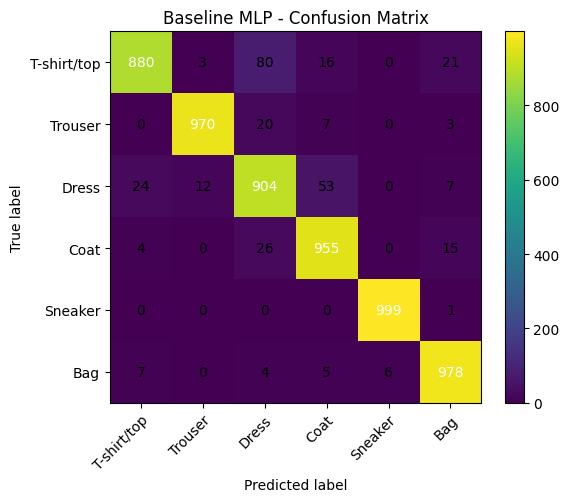

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 6)
        )
    def forward(self, x):
        return self.net(x)

def train_model(model, train_loader, val_loader, epochs=5, lr=1e-3):
    model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_val = 0.0
    for ep in range(1, epochs+1):
        model.train()
        running_loss, running_acc, count = 0.0, 0.0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)
            running_acc  += (logits.argmax(1) == yb).sum().item()
            count += xb.size(0)
        train_loss = running_loss / count
        train_acc  = running_acc  / count
        val_loss, val_acc, _, _ = evaluate(model, val_loader)
        print(f"Epoch {ep:02d} | train_loss={train_loss:.4f} acc={train_acc:.3f} | val_loss={val_loss:.4f} acc={val_acc:.3f}")
        if val_acc > best_val:
            best_val = val_acc
    return model

mlp = MLP()
mlp = train_model(mlp, train_loader, val_loader, epochs=5, lr=1e-3)

# Evaluate baseline on test set
test_loss, test_acc, test_pred, test_true = evaluate(mlp, test_loader)
print(f"[MLP] Test loss={test_loss:.4f} | Test acc={test_acc:.3f}")
print(classification_report(test_true, test_pred, target_names=CLASS_NAMES))
plot_confmat(test_true, test_pred, CLASS_NAMES, title="Baseline MLP - Confusion Matrix")


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 01 | train_loss=0.2860 acc=0.908 | val_loss=0.1765 acc=0.941
Epoch 02 | train_loss=0.1507 acc=0.951 | val_loss=0.1416 acc=0.953
Epoch 03 | train_loss=0.1243 acc=0.958 | val_loss=0.1274 acc=0.961
Epoch 04 | train_loss=0.1074 acc=0.963 | val_loss=0.1363 acc=0.951
Epoch 05 | train_loss=0.0941 acc=0.968 | val_loss=0.1179 acc=0.963
Epoch 06 | train_loss=0.0852 acc=0.970 | val_loss=0.1017 acc=0.968
[CNN] Test loss=0.0947 | Test acc=0.967
              precision    recall  f1-score   support

 T-shirt/top       0.95      0.95      0.95      1000
     Trouser       0.99      0.98      0.98      1000
       Dress       0.91      0.94      0.93      1000
        Coat       0.97      0.95      0.96      1000
     Sneaker       1.00      1.00      1.00      1000
         Bag       0.98      0.99      0.98      1000

    accuracy                           0.97      6000
   macro avg       0.97      0.97      0.97      6000
weighted avg       0.97      0.97      0.97      6000



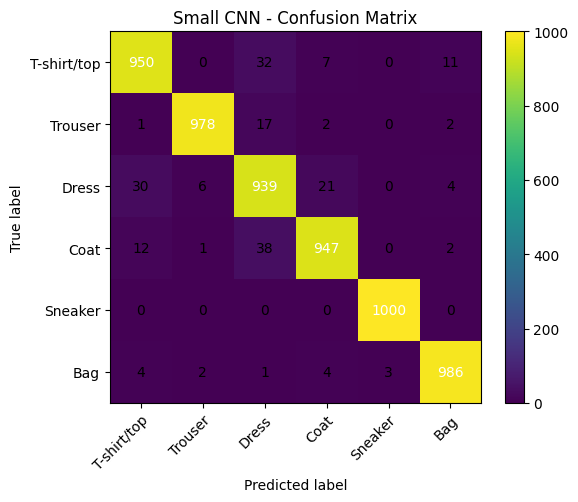

In [ ]:
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2,2)  # halves H,W
        self.fc1   = nn.Linear(32*7*7, 128)  # 28->14->7 after two pools
        self.fc2   = nn.Linear(128, 6)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 1->16, 28->14
        x = self.pool(F.relu(self.conv2(x)))  # 16->32, 14->7
        x = x.view(x.size(0), -1)             # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

cnn = SmallCNN()
cnn = train_model(cnn, train_loader, val_loader, epochs=6, lr=1e-3)

# Evaluate CNN on test
test_loss, test_acc, test_pred, test_true = evaluate(cnn, test_loader)
print(f"[CNN] Test loss={test_loss:.4f} | Test acc={test_acc:.3f}")
print(classification_report(test_true, test_pred, target_names=CLASS_NAMES))
plot_confmat(test_true, test_pred, CLASS_NAMES, title="Small CNN - Confusion Matrix")


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


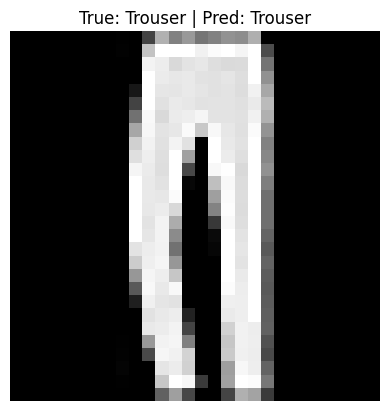

In [ ]:

def show_sample_and_pred(model, loader):
    model.eval()
    xb, yb = next(iter(loader))
    xb, yb = xb.to(DEVICE), yb.to(DEVICE)
    with torch.no_grad():
        logits = model(xb)
        pred = logits.argmax(1)
    idx = 0
    img = xb[idx].cpu().squeeze().numpy()
    plt.imshow(img, cmap="gray")
    plt.title(f"True: {CLASS_NAMES[int(yb[idx].cpu())]} | Pred: {CLASS_NAMES[int(pred[idx].cpu())]}")
    plt.axis('off'); plt.show()

show_sample_and_pred(cnn, test_loader)


<Figure size 640x480 with 0 Axes>

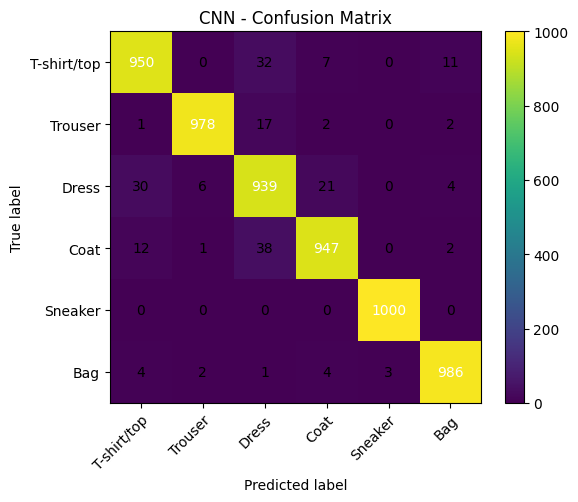

Saved cnn_confmat.png to notebook files.


In [ ]:
# Example: save last confusion matrix
fig = plt.figure()
plot_confmat(test_true, test_pred, CLASS_NAMES, title="CNN - Confusion Matrix")
fig.savefig("cnn_confmat.png", dpi=150, bbox_inches="tight")
print("Saved cnn_confmat.png to notebook files.")


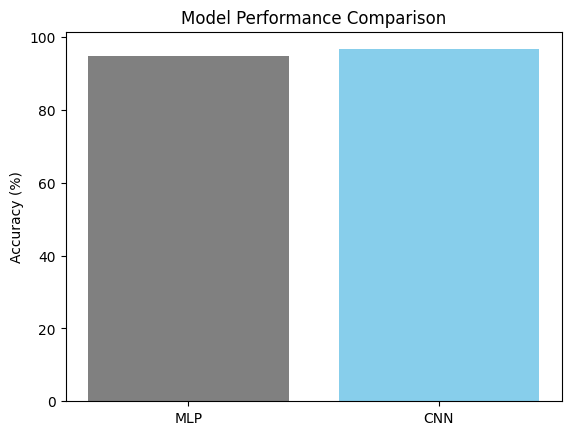

In [ ]:
import matplotlib.pyplot as plt
plt.bar(['MLP', 'CNN'], [94.8, 96.7], color=['gray','skyblue'])
plt.ylabel('Accuracy (%)')
plt.title('Model Performance Comparison')
plt.show()
